# Gaplock Plot Explorer
This notebook loads the CSV/JSON artifacts we dump under `plots/<scenario>/<run>/` and renders attacker/defender paths or heat maps.
1. Run training to produce `paths_<run>.csv` + `run_config_<run>.json`.
2. Point `run_dir` below to the folder that contains those files.
3. Execute the plotting cells to visualize trajectories.

In [8]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Set this to either the directory that already contains paths_*.csv / run_config_*.json
# files or leave it pointing at Path('plots') to auto-discover the latest run.
run_dir = Path('plots')

if not run_dir.exists():
    raise FileNotFoundError(f'{run_dir} does not exist')


def locate_latest_pair(search_root: Path):
    candidates = []
    for csv_path in search_root.rglob('paths_*.csv'):
        suffix = csv_path.stem.replace('paths_', '', 1)
        cfg_name = f'run_config_{suffix}.json'
        cfg_path = csv_path.with_name(cfg_name)
        if cfg_path.exists():
            candidates.append((csv_path.stat().st_mtime, csv_path, cfg_path))
    if not candidates:
        return None, None
    candidates.sort(key=lambda item: item[0])
    return candidates[-1][1], candidates[-1][2]


paths_csv, config_json = locate_latest_pair(run_dir)
if paths_csv is None:
    print(f'No paths_*.csv found under {run_dir}')
    df = pd.DataFrame()
    run_cfg = {}
else:
    print('Using', paths_csv)
    print('Config', config_json)
    df = pd.read_csv(paths_csv)
    with open(config_json) as fh:
        run_cfg = json.load(fh)
run_cfg


Using plots/eager-sweep-3/20251112-132218/paths_eager-sweep-3.csv
Config plots/eager-sweep-3/20251112-132218/run_config_eager-sweep-3.json


{'run_suffix': 'eager-sweep-3',
 'timestamp': '20251112-132218',
 'scenario': {'env': {'lidar_beams': 108,
   'map': 'line2',
   'max_steps': 1500,
   'seed': 42,
   'spawn_curriculum': {'activation_samples': 40,
    'cooldown': 20,
    'disable_patience': 2,
    'disable_rate': 0.3,
    'enable_patience': 4,
    'enable_rate': 0.7,
    'min_episode': 150,
    'persist': True,
    'success_window': 8},
   'spawn_point_sets': [{'id': 'offset_lane_a',
     'metadata': {'spawn_option_id': 'spawn_random'},
     'names': ['spawn_3', 'spawn_1']},
    {'id': 'offset_lane_b',
     'metadata': {'spawn_option_id': 'spawn_random'},
     'names': ['spawn_2', 'spawn_1']},
    {'id': 'extended_gap',
     'metadata': {'spawn_option_id': 'spawn_random'},
     'names': ['spawn_4', 'spawn_1']}],
   'spawn_points': ['spawn_2', 'spawn_1'],
   'terminate_on_any_done': True,
   'vehicle_params': {'length': 0.32,
    'v_max': 1.0,
    'v_min': -1.0,
    'width': 0.225}},
  'main': {'checkpoint': 'checkpoints

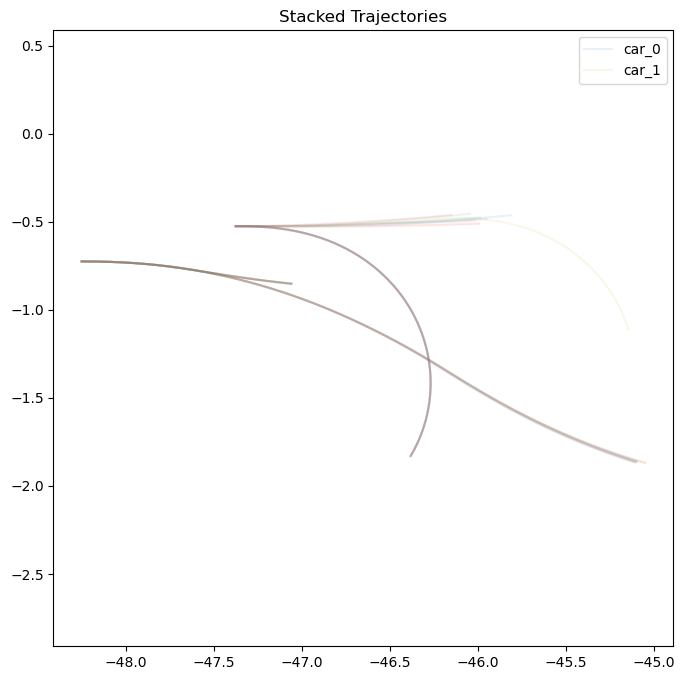

In [10]:
def plot_stacked_paths(dataframe, agents=None, max_episodes=None, stride=1):
    plt.figure(figsize=(8,8))
    agents = agents or dataframe['agent_id'].unique()
    for agent in agents:
        subset = dataframe[dataframe['agent_id'] == agent]
        episodes = sorted(subset['episode'].unique())[::stride]
        if max_episodes:
            episodes = episodes[:max_episodes]
        for ep in episodes:
            ep_df = subset[subset['episode'] == ep]
            plt.plot(ep_df['x'], ep_df['y'], alpha=0.1, label=f'{agent}' if ep == episodes[0] else '')
    plt.axis('equal')
    plt.legend()
    plt.title('Stacked Trajectories')
    plt.show()
plot_stacked_paths(df, agents=['car_0','car_1'])


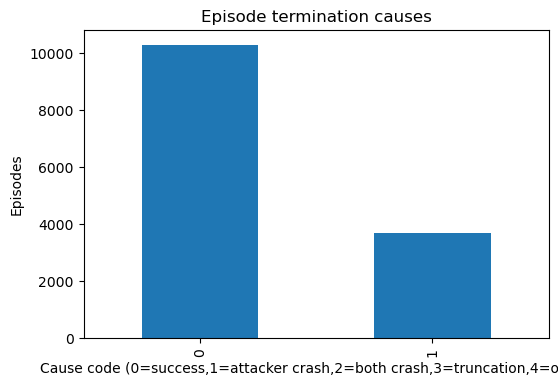

In [11]:
def plot_cause_histogram(dataframe):
    plt.figure(figsize=(6,4))
    dataframe['cause_code'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Cause code (0=success,1=attacker crash,2=both crash,3=truncation,4=other)')
    plt.ylabel('Episodes')
    plt.title('Episode termination causes')
    plt.show()
plot_cause_histogram(df)


In [12]:
import yaml
from PIL import Image


def load_map_geometry(run_config):
    map_name = None
    if isinstance(run_config, dict):
        if 'scenario' in run_config:
            map_name = run_config.get('scenario', {}).get('env', {}).get('map')
        if map_name is None:
            map_name = run_config.get('environment', {}).get('map')
    if not map_name:
        return None
    candidates = [
        Path('maps') / map_name / 'map.yaml',
        Path('maps') / map_name / f'{map_name}.yaml',
        Path('maps') / f'{map_name}.yaml',
        Path('maps') / f'{map_name}_map.yaml',
    ]
    map_path = next((p for p in candidates if p.exists()), None)
    if map_path is None:
        print(f"Warning: map metadata for {map_name!r} not found in maps/")
        return None
    with map_path.open() as fh:
        yaml_data = yaml.safe_load(fh)
    image_file = yaml_data.get('image')
    if image_file:
        image_path = map_path.parent / image_file
        if image_path.exists():
            yaml_data['_image_path'] = str(image_path)
    return yaml_data


map_bundle = load_map_geometry(run_cfg)
map_bundle


{'image': 'line2.pgm',
 'resolution': 0.05,
 'origin': [-51.224998, -51.224998, 0.0],
 'occupied_thresh': 0.65,
 'free_thresh': 0.196,
 'negate': 0,
 'annotations': {'finish_line': {'start': [45.7685, 0.6567],
   'end': [45.7144, -2.0465]},
  'spawn_points': [{'name': 'spawn_1', 'pose': [-48.2499, -0.724998, 0.0]},
   {'name': 'spawn_2', 'pose': [-46.769, 0.0768, 0.0]},
   {'name': 'spawn_3', 'pose': [-46.7917, -0.5922, 0.0]},
   {'name': 'spawn_4', 'pose': [-46.803, -1.2725, 0.0]},
   {'name': 'spawn_5', 'pose': [-45.4991, -1.7033, 0.0]},
   {'name': 'spawn_6', 'pose': [-45.4765, 0.2695, 0.0]}]},
 '_image_path': 'maps/line2/line2.pgm'}

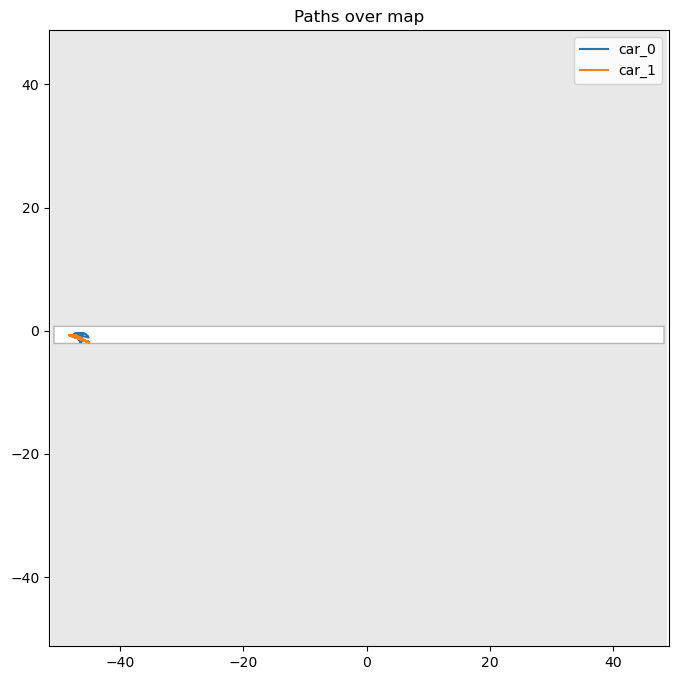

In [13]:
def plot_paths_with_map(dataframe, map_data, agents=('car_0', 'car_1'), episode=None):
    plt.figure(figsize=(8, 8))
    map_extent = None
    if map_data and '_image_path' in map_data:
        img = Image.open(map_data['_image_path'])
        width, height = img.size
        resolution = float(map_data.get('resolution', 1.0))
        origin = map_data.get('origin', [0.0, 0.0, 0.0])
        map_extent = [
            origin[0],
            origin[0] + width * resolution,
            origin[1],
            origin[1] + height * resolution,
        ]
        plt.imshow(img, extent=map_extent, cmap='gray', alpha=0.3, origin='upper')
    elif map_data and 'walls' in map_data:
        for wall in map_data['walls']:
            xs = [pt[0] for pt in wall]
            ys = [pt[1] for pt in wall]
            plt.plot(xs, ys, color='gray', linewidth=1)

    filtered = dataframe[dataframe['agent_id'].isin(agents)]
    if episode is not None:
        filtered = filtered[filtered['episode'] == episode]
    for agent in agents:
        subset = filtered[filtered['agent_id'] == agent]
        if subset.empty:
            continue
        plt.plot(subset['x'], subset['y'], label=agent)

    if map_extent and not filtered.empty:
        traj_x_min, traj_x_max = filtered['x'].min(), filtered['x'].max()
        traj_y_min, traj_y_max = filtered['y'].min(), filtered['y'].max()
        extent_x_min, extent_x_max = map_extent[0], map_extent[1]
        extent_y_min, extent_y_max = map_extent[2], map_extent[3]
        if (
            traj_x_min < extent_x_min
            or traj_x_max > extent_x_max
            or traj_y_min < extent_y_min
            or traj_y_max > extent_y_max
        ):
            print(
                'Warning: trajectory bounds extend outside map extent: '
                f'x=[{traj_x_min:.2f}, {traj_x_max:.2f}] vs '
                f'[{extent_x_min:.2f}, {extent_x_max:.2f}], '
                f'y=[{traj_y_min:.2f}, {traj_y_max:.2f}] vs '
                f'[{extent_y_min:.2f}, {extent_y_max:.2f}]'
            )

    plt.axis('equal')
    plt.legend()
    plt.title('Paths over map')
    plt.show()


plot_paths_with_map(df, map_bundle)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.ticker import FormatStrFormatter

# Parameters
veh_length = 0.32
veh_width = 0.225

anchor_forward = 1.2
anchor_lateral = 0.35
sigma = 0.55
peak = 1.0
floor = -0.5
power = 2.0

# Domain
x_min, x_max = -0.4, 2.2
y_min, y_max = -1.0, 1.0
nx, ny = 420, 340
xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(xs, ys)

# Anchors
c1 = np.array([anchor_forward,  anchor_lateral])
c2 = np.array([anchor_forward, -anchor_lateral])

D1 = np.hypot(X - c1[0], Y - c1[1])
D2 = np.hypot(X - c2[0], Y - c2[1])

G1 = np.exp(-0.5 * (D1 / sigma) ** power)
G2 = np.exp(-0.5 * (D2 / sigma) ** power)

# Combine without ridge
G = np.maximum(G1, G2)  # [0,1]

# Map to [floor, peak]
Z = floor + (peak - floor) * G

# Figure
fig, ax = plt.subplots(figsize=(5.4, 2.6), dpi=150)

im = ax.imshow(
    Z, extent=[x_min, x_max, y_min, y_max],
    origin="lower", aspect="equal", vmin=floor, vmax=peak
)

# Minimal contours
ax.contour(
    X, Y, Z,
    levels=[floor + 0.25*(peak-floor), floor + 0.5*(peak-floor), floor + 0.75*(peak-floor)],
    linewidths=0.6
)

# Target rectangle + heading
target_center = (0.0, 0.0)
ax.add_patch(patches.Rectangle(
    (target_center[0] - veh_length/2, target_center[1] - veh_width/2),
    veh_length, veh_width, fill=False, linewidth=2
))
ax.annotate("", xy=(target_center[0] + 0.18, target_center[1]),
            xytext=(target_center[0], target_center[1]),
            arrowprops=dict(arrowstyle="->", linewidth=2))
ax.text(target_center[0], target_center[1] + veh_width/2 + 0.05, "Target", ha="center", va="bottom")

# Anchor markers
ax.plot([c1[0], c2[0]], [c1[1], c2[1]], marker="x", linestyle="None",
        markersize=10, markeredgewidth=2)

# Colorbar with intermediate ticks including min/max
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)
cbar.set_label("potential")
ticks = np.linspace(floor, peak, 7)  # includes min/max + intermediates
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Axes
ax.set_xlabel("x (forward)")
ax.set_ylabel("y (lateral)")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

out_path = "reward_field.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)

out_path


'reward_field.png'

In [ ]:
# Spawn-point heatmaps from episode_metrics.csv
metrics_root = Path('outputs')


def locate_latest_metrics_pair(search_root: Path):
    candidates = []
    for csv_path in search_root.rglob('episode_metrics.csv'):
        cfg_path = csv_path.with_name('config_snapshot.json')
        if cfg_path.exists():
            candidates.append((csv_path.stat().st_mtime, csv_path, cfg_path))
    if not candidates:
        raise FileNotFoundError(
            f'No episode_metrics/config_snapshot files found under {search_root}'
        )
    candidates.sort(key=lambda item: item[0])
    return candidates[-1][1], candidates[-1][2]


metrics_csv, metrics_config = locate_latest_metrics_pair(metrics_root)
print('Using metrics', metrics_csv)
metrics_df = pd.read_csv(metrics_csv)
with open(metrics_config) as fh:
    metrics_snapshot = json.load(fh)
scenario_cfg = metrics_snapshot.get('config', {})
metrics_map = load_map_geometry(scenario_cfg)


def build_spawn_lookup(cfg, agent_id='car_0'):
    env_cfg = cfg.get('environment', {})
    spawn_cfgs = env_cfg.get('spawn_curriculum', {}).get('spawn_configs', {})
    mapping = {}
    if spawn_cfgs:
        for name, data in spawn_cfgs.items():
            pose = data.get(agent_id)
            if pose and len(pose) >= 2:
                mapping[name] = (float(pose[0]), float(pose[1]))
        return mapping

    map_data = load_map_geometry(cfg)
    spawn_points = (map_data or {}).get('annotations', {}).get('spawn_points', [])
    for sp in spawn_points:
        name = sp.get('name')
        pose = sp.get('pose')
        if name and pose and len(pose) >= 2:
            mapping[name] = (float(pose[0]), float(pose[1]))
    return mapping


def _plot_map_background(ax, map_data):
    if map_data and '_image_path' in map_data:
        img = Image.open(map_data['_image_path'])
        width, height = img.size
        resolution = float(map_data.get('resolution', 1.0))
        origin = map_data.get('origin', [0.0, 0.0, 0.0])
        map_extent = [
            origin[0],
            origin[0] + width * resolution,
            origin[1],
            origin[1] + height * resolution,
        ]
        ax.imshow(img, extent=map_extent, cmap='gray', alpha=0.3, origin='upper')
        return map_extent
    if map_data and 'walls' in map_data:
        for wall in map_data['walls']:
            xs = [pt[0] for pt in wall]
            ys = [pt[1] for pt in wall]
            ax.plot(xs, ys, color='gray', linewidth=1)
    return None


def plot_spawn_heatmaps(df, cfg, agent_id='car_0', success_outcome='target_crash'):
    if 'spawn_point' not in df.columns:
        print('spawn_point missing in episode_metrics.csv. Re-run with spawn logging enabled.')
        return
    data = df.copy()
    data = data[data['spawn_point'].notna() & (data['spawn_point'] != '')]
    if data.empty:
        print('No spawn_point entries to plot.')
        return
    data['success'] = data['outcome'] == success_outcome

    grouped = (
        data.groupby('spawn_point')['success']
        .agg(success_rate='mean', success_count='sum', episodes='count')
        .reset_index()
    )
    grouped['failure_count'] = grouped['episodes'] - grouped['success_count']

    lookup = build_spawn_lookup(cfg, agent_id=agent_id)
    points = []
    for _, row in grouped.iterrows():
        name = row['spawn_point']
        if name in lookup:
            x, y = lookup[name]
            points.append({**row, 'x': x, 'y': y})
    if not points:
        print('No spawn points matched config spawn coordinates.')
        return
    plot_df = pd.DataFrame(points)

    max_eps = plot_df['episodes'].max()
    sizes = 50 + 250 * (plot_df['episodes'] / max_eps)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=120)
    map_data = load_map_geometry(cfg)

    for ax in axes:
        _plot_map_background(ax, map_data)
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    sc0 = axes[0].scatter(
        plot_df['x'], plot_df['y'],
        s=sizes,
        c=plot_df['success_rate'],
        cmap='RdYlGn',
        vmin=0.0, vmax=1.0,
        edgecolors='black'
    )
    axes[0].set_title('Spawn Success Rate (color) + Episode Count (size)')
    fig.colorbar(sc0, ax=axes[0], fraction=0.046, pad=0.04, label='Success rate')

    sc1 = axes[1].scatter(
        plot_df['x'], plot_df['y'],
        s=sizes,
        c=plot_df['failure_count'],
        cmap='Reds',
        edgecolors='black'
    )
    axes[1].set_title('Spawn Failures (color) + Episode Count (size)')
    fig.colorbar(sc1, ax=axes[1], fraction=0.046, pad=0.04, label='Failure count')

    plt.tight_layout()
    plt.show()


plot_spawn_heatmaps(metrics_df, scenario_cfg, agent_id='car_0')
